<a href="https://colab.research.google.com/github/Mishra-0709/Techgium-Traction-Control-and-Torque-Compensation/blob/main/traction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.5 MB/s eta 0:00:00


     Slip  Brake_Energy
0  0.0000        0.0000
1  0.0002        1.0002
2  0.0004        2.0004
3  0.0006        3.0006
4  0.0008        4.0008
For longitudinal velocity = 30 m/s and slip ratio = 0.5:

Recommended braking torque: 50.00000000000001 Nm


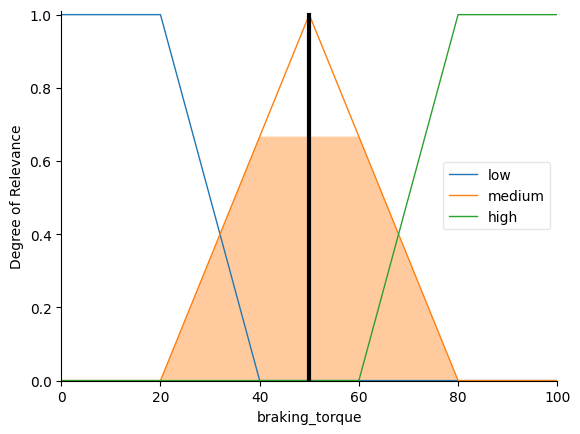

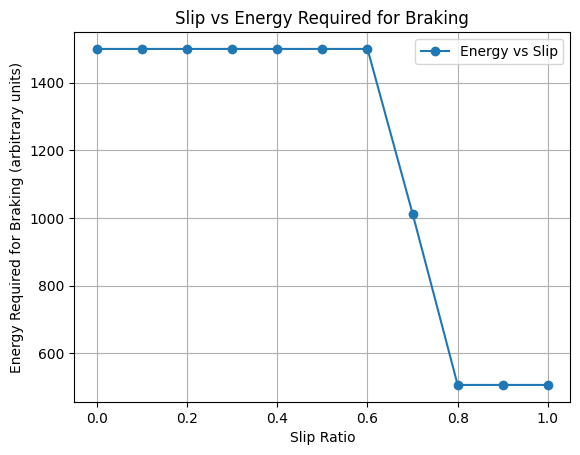

In [ ]:

import numpy as np
import pandas as pd
from skfuzzy import control as ctrl
import skfuzzy as fuzz
import matplotlib.pyplot as plt

data = pd.read_csv('expanded_slip_vs_brake_energy.csv')

# Display first few rows of the dataset to understand its structure
print(data.head())

# Define input and output variables for the fuzzy control system
longitudinal_velocity = ctrl.Antecedent(np.arange(0, 51, 1), 'longitudinal_velocity')  # in m/s
slip_ratio = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'slip_ratio')
braking_torque = ctrl.Consequent(np.arange(0, 101, 1), 'braking_torque')  # in Nm

# Define membership functions for longitudinal_velocity
longitudinal_velocity['low'] = fuzz.trapmf(longitudinal_velocity.universe, [0, 0, 10, 20])
longitudinal_velocity['medium'] = fuzz.trimf(longitudinal_velocity.universe, [10, 25, 40])
longitudinal_velocity['high'] = fuzz.trapmf(longitudinal_velocity.universe, [30, 40, 50, 50])

# Define membership functions for slip_ratio
slip_ratio['low'] = fuzz.trapmf(slip_ratio.universe, [0, 0, 0.2, 0.4])
slip_ratio['optimal'] = fuzz.trimf(slip_ratio.universe, [0.2, 0.5, 0.8])
slip_ratio['high'] = fuzz.trapmf(slip_ratio.universe, [0.6, 0.8, 1.0, 1.0])

# Define membership functions for braking_torque
braking_torque['low'] = fuzz.trapmf(braking_torque.universe, [0, 0, 20, 40])
braking_torque['medium'] = fuzz.trimf(braking_torque.universe, [20, 50, 80])
braking_torque['high'] = fuzz.trapmf(braking_torque.universe, [60, 80, 100, 100])

# Define fuzzy rules
rule1 = ctrl.Rule(longitudinal_velocity['low'] & slip_ratio['low'], braking_torque['low'])
rule2 = ctrl.Rule(longitudinal_velocity['low'] & slip_ratio['optimal'], braking_torque['medium'])
rule3 = ctrl.Rule(longitudinal_velocity['low'] & slip_ratio['high'], braking_torque['low'])

rule4 = ctrl.Rule(longitudinal_velocity['medium'] & slip_ratio['low'], braking_torque['medium'])
rule5 = ctrl.Rule(longitudinal_velocity['medium'] & slip_ratio['optimal'], braking_torque['medium'])
rule6 = ctrl.Rule(longitudinal_velocity['medium'] & slip_ratio['high'], braking_torque['low'])

rule7 = ctrl.Rule(longitudinal_velocity['high'] & slip_ratio['low'], braking_torque['high'])
rule8 = ctrl.Rule(longitudinal_velocity['high'] & slip_ratio['optimal'], braking_torque['medium'])
rule9 = ctrl.Rule(longitudinal_velocity['high'] & slip_ratio['high'], braking_torque['low'])

# Create control system and simulation
braking_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
braking_sim = ctrl.ControlSystemSimulation(braking_ctrl)

# Test the fuzzy control system with example data
test_velocity = 30  # m/s
test_slip_ratio = 0.5

braking_sim.input['longitudinal_velocity'] = test_velocity
braking_sim.input['slip_ratio'] = test_slip_ratio

# Compute the output
braking_sim.compute()

# Display the result
print(f"For longitudinal velocity = {test_velocity} m/s and slip ratio = {test_slip_ratio}:\n")
print(f"Recommended braking torque: {braking_sim.output['braking_torque']} Nm")

# Visualize the output membership function with updated label
braking_torque.view(sim=braking_sim)
plt.ylabel("Degree of Relevance")  # Replaced 'Membership' with 'Relevance'
plt.show()

# Calculate and plot slip vs energy required for braking
slip_values = np.arange(0, 1.1, 0.1)
energy_required = []

for slip in slip_values:
    braking_sim.input['longitudinal_velocity'] = test_velocity
    braking_sim.input['slip_ratio'] = slip
    braking_sim.compute()
    torque = braking_sim.output['braking_torque']
    # Assuming energy required is proportional to torque for simplicity
    energy = torque * test_velocity  # Simplified energy calculation
    energy_required.append(energy)

# Plot slip vs energy required
plt.figure()
plt.plot(slip_values, energy_required, marker='o', label='Energy vs Slip')
plt.xlabel('Slip Ratio')
plt.ylabel('Energy Required for Braking (arbitrary units)')
plt.title('Slip vs Energy Required for Braking')
plt.legend()
plt.grid()
plt.show()
